In [0]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from gensim.models import Word2Vec
from itertools import combinations
from scipy.io import mmread
import multiprocessing
import sys
import os
import time

In [0]:
!pip install -q stellargraph

In [0]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import BiasedRandomWalk
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import globalvar
from stellargraph import StellarGraph
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [0]:
def read_mtx(path):
    '''
    returns nx graph from MatrixMarket file
    '''
    a = mmread (path)
    return nx.from_scipy_sparse_matrix(a)

In [0]:
def read_net(path):
    '''
    retuns nx graph from net file
    '''
    
    G = nx.read_pajek(path)
    G = nx.relabel_nodes(G, {str(i): i for i in range(G.number_of_nodes())})
    return  G.to_undirected()

In [0]:
def split_graph(graph, p = 0.25):
    edge_splitter = EdgeSplitter(graph)
    return edge_splitter.train_test_split(p=0.25, method="global", keep_connected=True)

In [0]:
def mnap_k(predictions, true_values, k=10):
    '''
    predictions List[List[k]],
    true_values List[Set]
    '''

    #For each prediction check if it is correct (1 or 0), array [n, k]
    is_correct = np.array(list(map(lambda a, b: [x in b for x in a], predictions, true_values)), dtype = float)

    #Scores for a single prediction
    scores = is_correct * np.cumsum(is_correct, axis = 1) / np.cumsum(np.ones(is_correct.shape), axis = 1)

    #length of each set in true_values
    lengths = np.array([min(k, len(xi)) for xi in true_values])

    #getting void sets. For empty set summ of scores is always 0, as no prediction is correct
    voids = lengths == 0

    return np.mean(np.sum(scores, axis = 1)/ (lengths +  voids)) #for empty set term equals 0

In [0]:
class Similarity_predictor:
    def __init__(self, graph):
        '''
        graph - networkx graph we are predicting links for.
        '''
        self.graph = graph
        self.nodes = set(graph.nodes)
        self.similarity_matrix = None
        pass
        
    
    def fit(self, similarity_index='CN', use_inverse=True,
            restart_parameter=0.5, tolerance=1e-5, max_iter=10):
        '''
        similarity_index - type of similarity to use:
        CN - common neighbors
        PA - preferential attachment
        AA - Adamic-Adar 
        RA - resource allocation
        JC - Jacard's coefficicent
        RWR - random walk with return
        CNGF - CNGF Algorithm
        restart_parameter - probobility of continue random walk for RWR
        use_inverse - if true RWR method uses inverse matrix(recomended),
        max_iter - max iterations number if use_inverse is false
        '''
        
        #following may be not very effective, but it is clear what is happening
        def CommonNeighbours(pair):
            u, v = pair
            if (u == v):
                return 0
            similarity = len(set(self.graph.neighbors(u)) & set(self.graph.neighbors(v)))

            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity
        
        def JacardCoefficient(pair):
            u, v = pair
            if (u == v):
                return 0
            similarity = len(set(self.graph.neighbors(u)) & set(self.graph.neighbors(v))) / \
                         len(set(self.graph.neighbors(u)) | set(self.graph.neighbors(v)))
                        
            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity
        
        def PreferentialAttachment(pair):
            u, v = pair
            if (u == v):
                return 0
            
            similarity = self.graph.degree(u) * self.graph.degree(v)
        
            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity

        def AdamicAdar(pair):
            u, v = pair
            if (u == v):
                return 0
            
            common_neighbours = set(self.graph.neighbors(u)) & set(self.graph.neighbors(v))
            if (common_neighbours == set()):
                return 0
            degrees = np.array(list(self.graph.degree(common_neighbours)))[:,-1]
            similarity = (np.ones(degrees.shape[0]) / np.log(degrees)).sum()

            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity
        
        def ResourceAllocation(pair):
            u, v = pair
            if (u == v):
                return 0
            
            common_neighbours = set(self.graph.neighbors(u)) & set(self.graph.neighbors(v))
            if (common_neighbours == set()):
                return 0
            degrees = np.array(list(self.graph.degree(common_neighbours)))[:,-1]
            similarity = (np.ones(degrees.shape[0]) / degrees).sum()

            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity
        
        def CNGF(pair):
            u, v = pair
            if (u == v):
                return 0
            
            common_neighbours = set(self.graph.neighbors(u)) & set(self.graph.neighbors(v))
            if (common_neighbours == set()):
                return 0
            subgraph = self.graph.subgraph(common_neighbours | {u, v})
            sub_degrees = np.array(list(subgraph.degree(common_neighbours)))[:,-1]
            degrees = np.array(list(self.graph.degree(common_neighbours)))[:,-1]
            similarity = (sub_degrees / np.log(degrees)).sum()

            self.similarity_matrix[u, v] = similarity
            self.similarity_matrix[v, u] = similarity
       
        def inverse_RWR(transfer_matrix, restart_parameter):
            predict_matrix = None
            ok = False #in case matrix will be singular
            while not ok:
                try:
                    predict_matrix = (1 - restart_parameter) * np.linalg.inv(
                    np.eye(self.graph.number_of_nodes()) - restart_parameter * transfer_matrix.T)
                    ok = True

                except np.linalg.LinAlgError:
                    #we will change reset parameter a little to make matrix not singular
                    if (restart_parameter + tolerance < 1):
                        restart_parameter += tolerance
                    else:
                        restart_parameter -= tolerance
            return predict_matrix
        
        #using an iteration algorithm it is not recomended, as convergance may be very slow
        #and it does not handle singular matricies well
        def iterative_RWR(transfer_matrix):
            prev_matrix = None
            current_matrix = np.eye(self.graph.number_of_nodes())
            iterations = 0;

            while (iterations < max_iter) and ((prev_matrix is None) or \
            (np.linalg.norm(current_matrix - prev_matrix) / self.graph.number_of_nodes() >= tolerance)):

                prev_matrix = current_matrix
                current_matrix = restart_parameter * transfer_matrix.T @ prev_matrix +\
                (1 - restart_parameter) * np.eye(self.graph.number_of_nodes())
                iterations += 1
            
            return current_matrix
            
    
        func_dict = {'CN' : CommonNeighbours,
                     'PA' : PreferentialAttachment,
                     'AA' : AdamicAdar,
                     'RA' : ResourceAllocation,
                     'JC' : JacardCoefficient,
                     'CNGF': CNGF}
        
        self.similarity_matrix = np.zeros((self.graph.number_of_nodes(), self.graph.number_of_nodes()))
        if (similarity_index in func_dict.keys()):
            list(map(func_dict[similarity_index], combinations(range(self.graph.number_of_nodes()), 2)))
        elif (similarity_index == 'RWR'):
            
            assert restart_parameter <= 1 and restart_parameter >= 0
            transfer_matrix = nx.to_numpy_array(self.graph)
            presict_matrix = None
            sums = transfer_matrix.sum(axis=1)
            transfer_matrix[sums > 0] /= sums[sums > 0][:, None]
            
            if use_inverse:
                predict_matrix = inverse_RWR(transfer_matrix, restart_parameter)
            else:
                predict_matrix = iterative_RWR(transfer_matrix)
                
            self.similarity_matrix = (predict_matrix.T + predict_matrix) / 2         
        else:
            print('wrong similarity index')


    def predict(self, pred_num):
        '''
        pred_num - number of predictions to make
        '''
        
        def get_top_k(node):
            not_included = list(self.nodes - set(self.graph.neighbors(node)) - {node})
            possible_neighbours = np.arange(0, self.graph.number_of_nodes())[not_included]
            pred_for_node = np.flipud(
                possible_neighbours[np.argsort(
                    self.similarity_matrix[node][not_included]
                )[-pred_num:]]
            )
        
            assert pred_for_node.shape[0] == pred_num

            return pred_for_node
        
        predictions = []
        for node in self.nodes:
            predictions.append(get_top_k(node))
        return np.array(predictions)

In [0]:
#parameters
p = 1.0 #return parameter
q = 1.0 # in-out parameter
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1 #SGD parameter
workers = multiprocessing.cpu_count()

def node2vec_embedding(graph):
		rw = BiasedRandomWalk(graph)
		walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
	
		#convert indicies to words
		walks = [list(map(str, walk)) for walk in walks]

		model = Word2Vec(
				walks,
				size=dimensions,
				window=window_size,
				min_count=0,
				sg=1,
				workers=workers,
				iter=num_iter
		)

		def get_embedding(u):
				return model.wv[str(u)]

		return  np.array(list(map(get_embedding, range(graph.number_of_nodes()))))

In [0]:
#binary operators to create edges embeddings
def mean(u, v):
    return (u + v) / 2

def L1(u, v):
    return np.abs(u - v)

def L2(u, v):
    return (u - v) ** 2

def mult(u, v):
    return u * v

In [0]:
#creation of training data from embeddings
def create_train(graph, embeddings, operator=mean):
    '''
    retunrs array of features E X k and their labels
    '''
    #muting output
    stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    seed = 0
    succsess = False

    #function can behave incorrectly, so we will be carefull
    edges_train = None
    labels = None
    while not succsess:
        try:
            splitter = EdgeSplitter(graph)
            #getting half of existing and the same amount of not existing

            _, edges_train, labels = splitter.train_test_split(p=0.5, method='global')
            succsess = True
        except ValueError:
            seed += 1

    #get output back
    sys.stdout = stdout

    #generating features
    train_features = np.array(
        list(
            map(
              lambda x: 
                  operator(embeddings[x[0]], embeddings[x[1]]),
              edges_train
            )
        )
    )
    
    return train_features, labels

In [0]:
def test_data_generator(graph, embeddings, operator=mean):
    '''
    yeilds edges embeddings array and list of nodes for a current node
    ''' 
    nodes_set = set(graph.nodes())
    for node in graph.nodes():
        neighbors_set = set(graph.neighbors(node))
        possible_neighbors_set = nodes_set - neighbors_set - {node}

        #generating features
        features = np.array(
            list(
                map(
                    lambda v: operator(embeddings[node], embeddings[v]),
                    possible_neighbors_set
                )
            )
        )

        #yield batch
        yield features, np.array(list(possible_neighbors_set))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#reading file
G = read_mtx('/content/socfb-MIT.mtx')

#getting test data
G_train, edge_list_test, labels = split_graph(G)

#getting adjacency list for it
adjacency_list_test = [set() for _ in range(G.number_of_nodes())]
for edge in edge_list_test[labels == 1]:
    adjacency_list_test[edge[0]].add(edge[1])
    adjacency_list_test[edge[1]].add(edge[0])

** Sampled 62807 positive and 62807 negative edges. **


In [0]:
#getting results for Similarity based approaches
similarity_indicies = ['CN', 'PA', 'AA', 'RA', 'JC', 'CNGF']
time_consumed = []
results = []

predictor = Similarity_predictor(G_train)
for index in similarity_indicies:
    print(index, 'started')
    start_time = time.time()
    predictor.fit(similarity_index = index)
    predictions = predictor.predict(10)
    time_consumed.append(time.time() - start_time)
    results.append(mnap_k(predictions, adjacency_list_test))
    print(index, 'finished')

In [0]:
#getting best result for RWR
best_res = 0
best_parameter = 0
rwr_time_consumed = 0

for c in np.linspace(0, 1, 20):
    print(c)
    start_time = time.time()
    predictor.fit(similarity_index='RWR', restart_parameter=c)
    predictions = predictor.predict(10)
    current_time_consumed = time.time() - start_time
    res = mnap_k(predictions, adjacency_list_test)
    if (res > best_res):
        best_res = res
        best_parameter = c
        rwr_time_consumed = current_time_consumed

In [0]:
#Saving the results
f = open('drive/My Drive/results.txt', 'w')
for i in range(len(similarity_indicies)):
    f.write("{} {} {}\n".format(similarity_indicies[i], results[i], time_consumed[i]))
f.write("{} {} {} c = {}\n".format('RWR', best_res, rwr_time_consumed, best_parameter))
f.close()

In [0]:
G_train_nx = StellarGraph.from_networkx(G_train)

In [0]:
#finding 'optimal' p and q parameters
#start with p
p = 0.5 #return parameter
q = 0.6 # in-out parameter
dimensions = 5 
num_walks = 5
walk_length = 15 
window_size = 5
num_iter = 1 #SGD parameter

ans = [] #mnap result
times = [] #time consumed

for pp in np.linspace(0.05, 1, num=20):

  #getting embeddings with new p
  t1 = time.time()
  p = pp
  print(p)
  embeddings = node2vec_embedding(G_train_nx)
  t2 = time.time()
  print('embedings done')

  #getting train data for these embeddings
  X_train, Y_train = create_train(G_train, embeddings, L2)

  #fitting the LogRegression model
  t3 = time.time()
  model = LogisticRegression()
  model.fit(X_train, Y_train)
  t4 = time.time()

  #saving time intervals
  times.append((t2 - t1, t3 - t2, t4 - t3)) 

  #getting predictions only for 500 first nodes
  i = 0
  preds = []
  for features, pairs in test_data_generator(G_train, embeddings, L2):
    preds.append(pairs[np.argsort(model.predict_proba(features)[:, 0])][:10])
    i += 1
    if i == 500:
      break
    print('\r', i, end = '')
  print('\r', i)
  less_list = np.array(adjacency_list_test)[:500]
  ans.append(mnap_k(preds[:500], less_list))
  print(mnap_k(preds[:500], less_list))

Text(0, 0.5, 'Оценка качества')

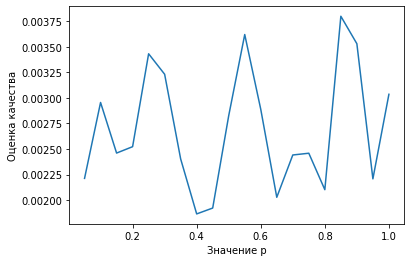

In [0]:
#p results
plt.plot(np.linspace(0.05, 1, num=20), ans)
plt.xlabel("Значение p")
plt.ylabel("Оценка качества")

In [0]:
f = open('drive/My Drive/p_results.txt', 'w')
for i in range(len(ans)):    
  f.write("{} {}\n".format(ans[i], times[i][0]))
f.close()

In [0]:
#now q, (the same way as p)
q = 0.6 # in-out parameter
dimensions = 5 #128
num_walks = 5
walk_length = 15 #80
window_size = 5
num_iter = 1 #SGD parameter

ans = []
times = []

for pp in np.linspace(0.05, 1, num=20):
  t1 = time.time()
  q = pp
  print(q)
  embeddings = node2vec_embedding(G_train_nx)
  t2 = time.time()
  print('embedings done')
  X_train, Y_train = create_train(G_train, embeddings, mean)
  t3 = time.time()
  model = LogisticRegression()
  model.fit(X_train, Y_train)
  t4 = time.time()
  times.append((t2 - t1, t3 - t2, t4 - t3))
  i = 0
  preds = []
  for features, pairs in test_data_generator(G_train, embeddings, L2):

    preds.append(pairs[np.argsort(model.predict_proba(features)[:, 0])][:10])
    i += 1
    if i == 500:
      break
    print('\r', i, end = '')
  print('\r', i)
  less_list = np.array(adjacency_list_test)[:500]
  ans.append(mnap_k(preds[:500], less_list))
  print(mnap_k(preds[:500], less_list))

Text(0, 0.5, 'Оценка качества')

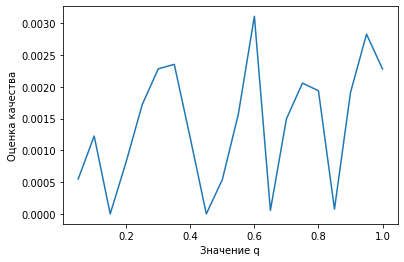

In [0]:
#q results
plt.plot(np.linspace(0.05, 1, num=20), ans)
plt.xlabel("Значение q")
plt.ylabel("Оценка качества")

In [0]:
#saving results
f = open('drive/My Drive/q_results.txt', 'w')
for i in range(len(ans)):
    f.write("{} {}\n".format(ans[i], times[i][0]))
f.close()

In [0]:
#Compairing operetors results for LogRegression

p = 0.85 #return parameter
q = 0.6 # in-out parameter
dimensions = 32 #128
num_walks = 20
walk_length = 40 #80
window_size = 10
num_iter = 5 #SGD parameter

embeddings = node2vec_embedding(G_train_nx)

ans = []
times = []

for method in [mean, L1, L2, mult]:
  #creating train data
  print('starting method')
  t1 = time.time()
  X_train, Y_train = create_train(G_train, embeddings, method)
  t2 = time.time()

  #fitting model
  print('training data created')
  model = LogisticRegression()
  model.fit(X_train, Y_train)
  t3 = time.time()
  
  #predicting
  i = 0
  preds = []
  for features, pairs in test_data_generator(G_train, embeddings, method):
    preds.append(pairs[np.argsort(model.predict_proba(features)[:, 0])][:10])
    i += 1
    print('\r', i, end = '')
  print('\r', i)
  t4 = time.time()

  times.append((t2 - t1, t3 - t2, t4 - t3)) 

  ans.append(mnap_k(preds, adjacency_list_test))
  print(mnap_k(preds, adjacency_list_test))

In [0]:
#Saving results
f = open('drive/My Drive/Logicstic_metrics.txt', 'w')
f.write("mnap_k create_train fit_time prdeict_time\n")
for i in range(len(ans)):
    f.write("{} {} {} {}\n".format(ans[i], times[i][0], times[i][1], times[i][2]))
f.close()

In [0]:
#Same for SVM model

p = 0.85 #return parameter
q = 0.6 # in-out parameter
dimensions = 32 #128
num_walks = 20
walk_length = 40 #80
window_size = 10
num_iter = 5 #SGD parameter

ans = []
times = []

embeddings = node2vec_embedding(G_train_nx)

for method in [mean, L1, L2, mult]:
  print('starting method')
  t1 = time.time()
  X_train, Y_train = create_train(G_train, embeddings, method)
  print('training data created')
  t2 = time.time()
  model = LinearSVC()
  model.fit(X_train, Y_train)
  t3 = time.time()
  
  i = 0
  preds = []
  for features, pairs in test_data_generator(G_train, embeddings, method):
    preds.append(pairs[np.argsort(-model.decision_function(features))][:10])
    i += 1
    print('\r', i, end = '')
  print('\r', i)
  t4 = time.time()
  times.append((t2 - t1, t3 - t2, t4 - t3))

  ans.append(mnap_k(preds, adjacency_list_test))
  print(mnap_k(preds, adjacency_list_test))

In [0]:
#Saving results
f = open('drive/My Drive/svd_metrics.txt', 'w')
f.write("mnap_k create_train fit_time prdeict_time\n")
for i in range(len(ans)):
    f.write("{} {} {} {}\n".format(ans[i], times[i][0], times[i][1], times[i][2]))
f.close()

SageGraph

In [0]:
G_small, edge_list_train, labels_train = split_graph(G_train)

** Sampled 47105 positive and 47105 negative edges. **


In [0]:
p = 0.85 #return parameter
q = 0.6 # in-out parameter
dimensions = 32 #128
num_walks = 20
walk_length = 40 #80
window_size = 10
num_iter = 5 #SGD parameter

embeddings = node2vec_embedding(G_train_nx)

In [0]:
for i in range(len(G_train.nodes)):
  G_small.nodes[i]["feature"] = embeddings[i]
  G_train.nodes[i]["feature"] = embeddings[i]

In [0]:
G_sg_train = sg.StellarGraph(G_small, node_features="feature")
G_sg_test = sg.StellarGraph(G_train, node_features="feature")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  


In [0]:
print(G_sg_train.info())

StellarGraph: Undirected multigraph
 Nodes: 6402, Edges: 141318

 Node types:
  default: [6402]
    Features: float32 vector, length 32
    Edge types: default-default->default

 Edge types:
    default-default->default: [141318]
        Weights: all 1 (default)
        Features: none


In [0]:
batch_size = 20
epochs = 10

num_samples = [20, 10]


train_gen0 = GraphSAGELinkGenerator(G_sg_train, batch_size, num_samples)
train_gen = train_gen0.flow(edge_list_train, labels_train)
test_gen0 = GraphSAGELinkGenerator(G_sg_test,  batch_size, num_samples)
test_gen = test_gen0.flow(edge_list_test, labels)

In [0]:
layer_sizes = [10, 10]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(layer_sizes=layer_sizes, generator=train_gen0, bias=True, dropout=0.3) #Построение нееросетки


x_inp, x_out = graphsage.build()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The 'build' method is deprecated, use 'in_out_tensors' instead.
  import sys


In [0]:
prediction = link_classification(
            output_dim=1, output_act="relu", edge_embedding_method='ip'
        )(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"]) #компиляция модели

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [0]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

Instructions for updating:
Please use Model.evaluate, which supports generators.

Train Set Metrics of the initial (untrained) model:
	loss: 0.8765
	acc: 0.5443

Test Set Metrics of the initial (untrained) model:
	loss: 0.8858
	acc: 0.5399


In [0]:
history = model.fit_generator(
            train_gen,
            epochs=epochs,
            validation_data=test_gen,
            verbose=2
        )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
4711/4711 - 366s - loss: 0.6144 - acc: 0.6908 - val_loss: 0.5507 - val_acc: 0.7180
Epoch 2/10
4711/4711 - 367s - loss: 0.5519 - acc: 0.7314 - val_loss: 0.5205 - val_acc: 0.7460
Epoch 3/10
4711/4711 - 371s - loss: 0.5297 - acc: 0.7511 - val_loss: 0.5005 - val_acc: 0.7678
Epoch 4/10
4711/4711 - 368s - loss: 0.5206 - acc: 0.7519 - val_loss: 0.4894 - val_acc: 0.7731
Epoch 5/10
4711/4711 - 365s - loss: 0.5084 - acc: 0.7661 - val_loss: 0.4808 - val_acc: 0.7802
Epoch 6/10
4711/4711 - 368s - loss: 0.5015 - acc: 0.7704 - val_loss: 0.4832 - val_acc: 0.7805
Epoch 7/10
4711/4711 - 373s - loss: 0.5051 - acc: 0.7728 - val_loss: 0.5368 - val_acc: 0.7315
Epoch 8/10
4711/4711 - 368s - loss: 0.4975 - acc: 0.7723 - val_loss: 0.4760 - val_acc: 0.7854
Epoch 9/10
4711/4711 - 367s - loss: 0.4982 - acc: 0.7733 - val_loss: 0.4748 - val_acc: 0.7856
Epoch 10/10
4711/4711 - 368s - loss: 0.4892 - acc: 0.7764 - val_loss: 0.5087 -

In [0]:
t3 = time.time()
preds = []
i = 0
for features, pairs in test_data_generator(G_train, embeddings):
    labels = np.array([1 for i in pairs])
    edges = [[j, x] for x in pairs]
    test_gen = test_gen0.flow(edges, labels)
    #print(model.predict(test_gen)[:, 0])
    preds.append(pairs[np.argsort(-model.predict(test_gen)[:, 0])][:10])
    i += 1
    print('\r', i, end = '')
    if i == 100:
      break
print('\r', i)
t4 = time.time()

print(mnap_k(preds[:100], adjacency_list_test[:100]))

 100
0.0007746913580246914


In [0]:
t4-t3

1252.1709802150726